<a href="https://colab.research.google.com/github/williamedwardhahn/ComplexSystems/blob/main/Complex_Systems_Lab_LCA_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TPU Matmul Speed Test

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
import torch
import torch_xla
import torch_xla.core.xla_model as xm

In [ ]:
dev = xm.xla_device()
# dev = torch.device('cuda')

In [ ]:
a = torch.randn(4096, 4096, device = dev)
b = torch.randn(4096, 4096, device = dev)

In [ ]:
%%timeit
torch.matmul(a, b)

The slowest run took 5081.39 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.03 µs per loop


In [ ]:
dev

device(type='xla', index=1)

# LCA on TPU

In [ ]:
from __future__ import division
import numpy as np
import sklearn.preprocessing as skp
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import scipy.io as sio
from skimage.util import montage
def plot(x):
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(18, 10)
    plt.show()
    
def bar(a):
    x = np.arange(a.shape[0])
    fig, ax = plt.subplots()
    plt.bar(x, a)
    # plt.xticks(x, ('0', '1', '2', '3', '4','5', '6', '7', '8', '9'))
    plt.show()

In [ ]:
!wget https://github.com/williamedwardhahn/sparse/raw/master/dict512.mat

--2021-01-23 17:43:18--  https://github.com/williamedwardhahn/sparse/raw/master/dict512.mat
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/williamedwardhahn/sparse/master/dict512.mat [following]
--2021-01-23 17:43:18--  https://raw.githubusercontent.com/williamedwardhahn/sparse/master/dict512.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 992670 (969K) [application/octet-stream]
Saving to: ‘dict512.mat’

dict512.mat         100%[===================>] 969.40K  --.-KB/s    in 0.07s   

2021-01-23 17:43:19 (14.2 MB/s) - ‘dict512.mat’ saved [992670/992670]



In [ ]:
!wget https://github.com/williamedwardhahn/sparse/raw/master/patches.mat

--2021-01-23 17:43:19--  https://github.com/williamedwardhahn/sparse/raw/master/patches.mat
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/williamedwardhahn/sparse/master/patches.mat [following]
--2021-01-23 17:43:19--  https://raw.githubusercontent.com/williamedwardhahn/sparse/master/patches.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81247942 (77M) [application/octet-stream]
Saving to: ‘patches.mat’

patches.mat         100%[===================>]  77.48M   121MB/s    in 0.6s    

2021-01-23 17:43:20 (121 MB/s) - ‘patches.mat’ saved [81247942/81247942]



In [ ]:
D = sio.loadmat('dict512.mat')['Wp'].T

In [ ]:
P = sio.loadmat('patches.mat')['data'].T

In [ ]:
D.shape,P.shape

((256, 512), (50000, 256))

In [ ]:
r = np.random.permutation(D.shape[1])

In [ ]:
# D = D[:,r[0:256]] 

In [ ]:
y = P[0:1024,:]

In [ ]:
D = torch.tensor(D,device=dev)
y = torch.tensor(y,device=dev)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [ ]:
y.shape,D.shape

(torch.Size([1024, 256]), torch.Size([256, 512]))

In [ ]:
eye1 = torch.eye(D.shape[1],device=dev)

In [ ]:
N = 300
a = 0.01
adapt = 0.99
lamb = 0.05

In [ ]:
zero = torch.zeros((1,),device=dev)

In [ ]:
def LCA(D,y):

    u = torch.zeros((y.shape[0], D.shape[1]),device=dev)

    s = torch.zeros(u.shape,device=dev)

    c = torch.matmul(D.T,D) - eye1

    b = torch.matmul(y,D)

    for i in range(N):

        u = a*(b-torch.matmul(s,c))+(1-a)*u
        
        s = torch.sign(u)*torch.absolute(u)

    return s.T

In [ ]:
x = LCA(D,y)

In [ ]:
%%timeit
x = LCA(D,y)

100 loops, best of 3: 17.6 ms per loop


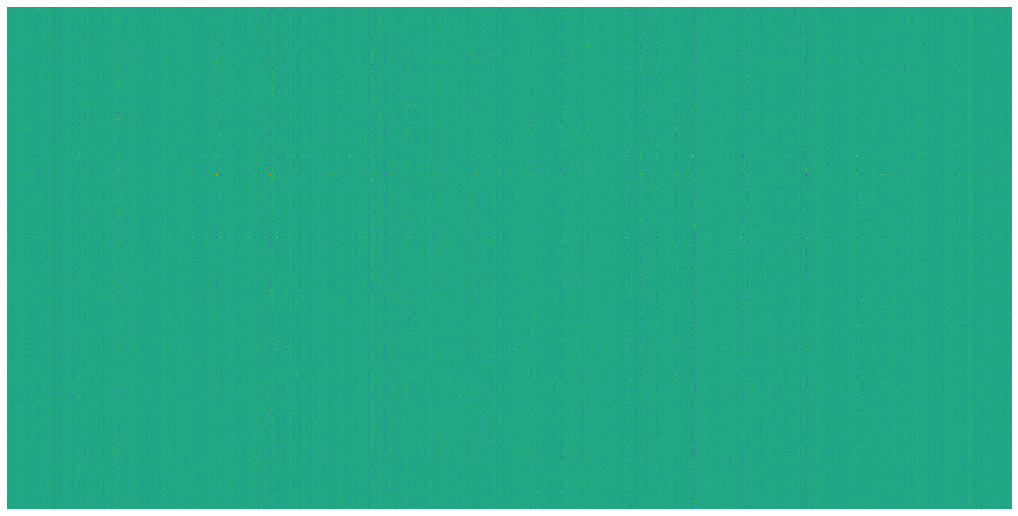

In [ ]:
plot(x.cpu().numpy())

In [ ]:
y2 = D@x

In [ ]:
y2 = y2.cpu().numpy()

In [ ]:
y2.shape,D.shape,x.shape

((256, 1024), torch.Size([256, 512]), torch.Size([512, 1024]))

In [ ]:
y3 = np.reshape(y2.T,(y2.shape[1],16,16))

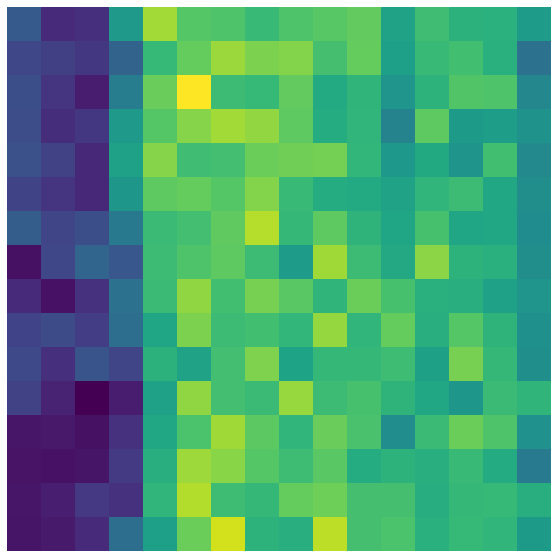

In [ ]:
plot(y3[0]) #recon

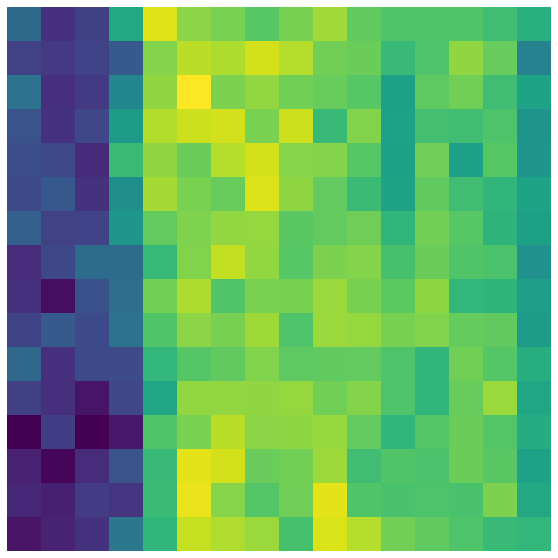

In [ ]:
plot(y[0,:].cpu().numpy().reshape(16,16)) #original

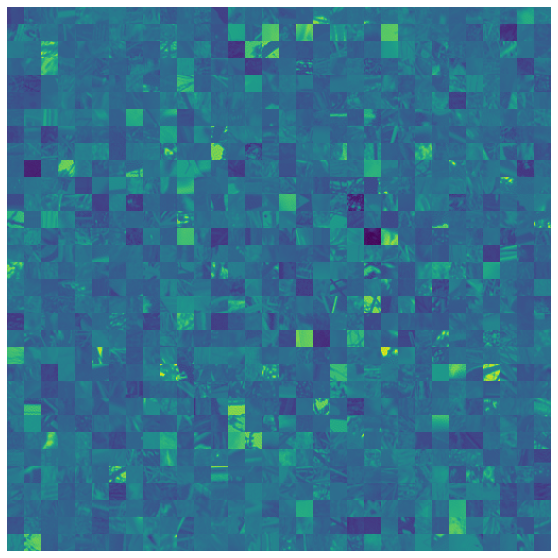

In [ ]:
plot(montage(y3)) #recon

In [ ]:
y0 = np.reshape(y.cpu().numpy(),(y.shape[0],16,16))

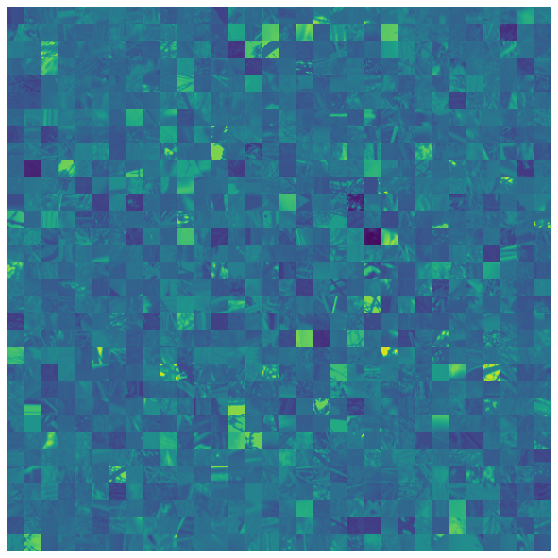

In [ ]:
plot(montage(y0)) #originals

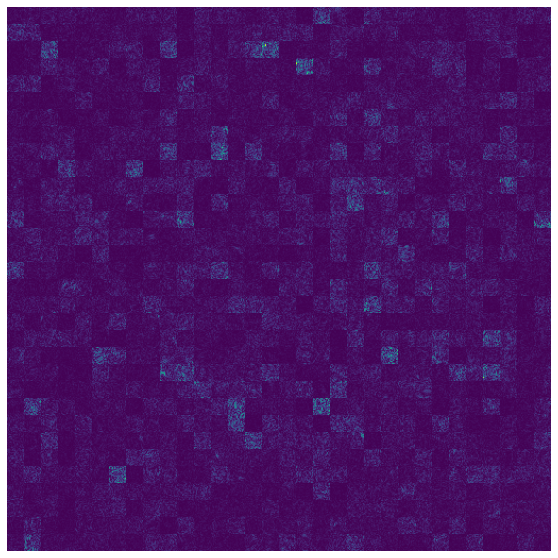

In [ ]:
plot(montage(np.abs(y0-y3))) # coding error